#5

(a)

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('mall_customers.csv')

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data[['Annual_Income', 'Spending_Score']])


def initialize_parameters(K, data):
    np.random.seed(42)
    n_samples, n_features = data.shape

    # Initialize weights, means, and covariances
    weights = np.ones(K) / K
    means = data[np.random.choice(n_samples, K, replace=False)]
    covariances = np.array([0.01 * np.eye(n_features)] * K)

    return weights, means, covariances

def calculate_likelihood(data, weights, means, covariances, K):
    likelihood = np.zeros((len(data), K))

    for k in range(K):
        likelihood[:, k] = weights[k] * multivariate_normal.pdf(data, means[k], covariances[k])

    return likelihood

def expectation_step(data, weights, means, covariances, K):
    likelihood = calculate_likelihood(data, weights, means, covariances, K)
    total_likelihood = np.sum(likelihood, axis=1, keepdims=True)

    # Calculate responsibilities
    responsibilities = likelihood / total_likelihood

    return responsibilities

def maximization_step(data, responsibilities, K):
    n_samples, n_features = data.shape
    weights = np.sum(responsibilities, axis=0) / n_samples
    means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0)[:, np.newaxis]

    covariances = np.zeros((K, data.shape[1], data.shape[1]))
    for k in range(K):
        diff = data - means[k]
        covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / np.sum(responsibilities[:, k])+ 10**-6 * np.eye(n_features)

    return weights, means, covariances

def score_samples(data, weights, means, covariances, K):
    likelihood = calculate_likelihood(data, weights, means, covariances, K)
    log_likelihoods = np.log(np.sum(likelihood, axis=1))
    return np.sum(log_likelihoods)

def gmm_algorithm(data, K, max_iter=100, tol=1e-4):
    weights, means, covariances = initialize_parameters(K, data)

    prev_log_likelihood = -np.inf
    for i in range(max_iter):
        # Expectation step
        responsibilities = expectation_step(data, weights, means, covariances, K)

        # Maximization step
        weights, means, covariances = maximization_step(data, responsibilities, K)

        # Calculate log-likelihood
        current_log_likelihood = score_samples(data, weights, means, covariances, K)

        # Check for convergence
        if np.abs(current_log_likelihood - prev_log_likelihood) < tol:
            break

        prev_log_likelihood = current_log_likelihood

    return weights, means, covariances, responsibilities

1

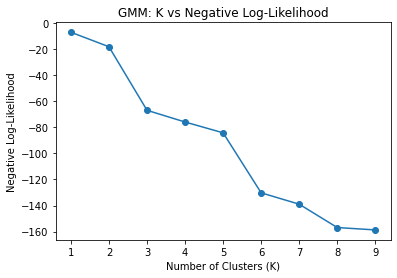

In [24]:
# Plot the relationship between K and negative log-likelihood
K_values = range(1, 10)
log_likelihoods = []

for K in K_values:
    weights, means, covariances, responsibilities = gmm_algorithm(normalized_data, K)
    log_likelihoods.append(-score_samples(normalized_data, weights, means, covariances, K))

plt.plot(K_values, log_likelihoods, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Negative Log-Likelihood')
plt.title('GMM: K vs Negative Log-Likelihood')
plt.show()

I can  select a proper K for this dataset, which is 6

2

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12468\1361929282.py:23: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))


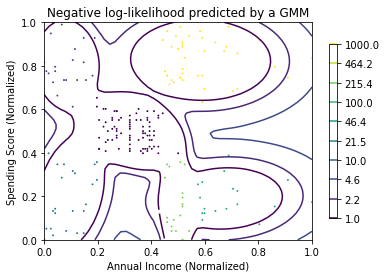

In [25]:
from matplotlib.colors import LogNorm

def calculate_neg_log_likelihood(data, weights, means, covariances, K):
    likelihood = calculate_likelihood(data, weights, means, covariances, K)
    log_likelihoods = np.log(np.sum(likelihood, axis=1))
    return -np.sum(log_likelihoods)

# Set the random seed for reproducibility
np.random.seed(42)

# Fit Gaussian Mixture Model
K = 6  # Change this to your selected K value
weights, means, covariances, responsibilities = gmm_algorithm(normalized_data, K)

x = np.linspace(0, 1)
y = np.linspace(0, 1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.array([calculate_neg_log_likelihood(np.array([sample]), weights, means, covariances, K) for sample in XX])
Z = Z.reshape(X.shape)

# Plotting
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], 0.8, c=np.argmax(responsibilities, axis=1))

plt.title("Negative log-likelihood predicted by a GMM")
plt.xlabel('Annual Income (Normalized)')
plt.ylabel('Spending Score (Normalized)')
plt.axis("tight")
plt.show()

3

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12468\2858586087.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))


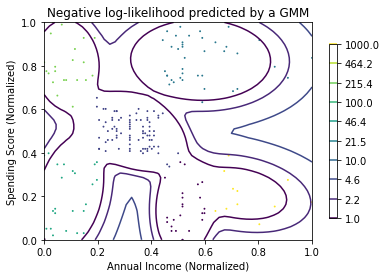

In [26]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=K, covariance_type='full', init_params='kmeans')
gmm.fit(normalized_data)

# display predicted scores by the model as a contour plot
x = np.linspace(0, 1)
y = np.linspace(0, 1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], 0.8, c=gmm.predict(normalized_data))

plt.title("Negative log-likelihood predicted by a GMM")
plt.xlabel('Annual Income (Normalized)')
plt.ylabel('Spending Score (Normalized)')
plt.axis("tight")
plt.show()

It shows similar results

(b)

In [27]:
def initialize_centers(data, K):
    # Randomly initialize K centers from the data points
    np.random.seed(42)
    centers = data[np.random.choice(data.shape[0], K, replace=False)]
    return centers

def assign_clusters(data, centers):
    # Calculate distances between each point and all centers
    distances = np.sqrt(((data - centers[:, np.newaxis])**2).sum(axis=2))
    # Assign each point to the closest cluster
    clusters = np.argmin(distances, axis=0)
    return clusters

def update_centers(data, clusters, K):
    # Update centers to be the mean of all points in the cluster
    centers = np.array([data[clusters == k].mean(axis=0) for k in range(K)])
    return centers

def calculate_mean_distance(data, centers, clusters):
    # Calculate mean distance between cluster centroids and assigned samples
    distances = np.sqrt(((data - centers[clusters])**2).sum(axis=1))
    mean_distance = np.mean(distances)
    return mean_distance

def k_means(data, K, max_iter=100, tol=1e-4):
    # Initialize centers
    centers = initialize_centers(data, K)
    prev_centers = centers.copy()
    
    for _ in range(max_iter):
        # Assign points to clusters
        clusters = assign_clusters(data, centers)
        
        # Update centers
        centers = update_centers(data, clusters, K)
        
        # Calculate mean distance
        mean_distance = calculate_mean_distance(data, centers, clusters)
        
        # Check convergence
        if np.linalg.norm(centers - prev_centers) < tol:
            break
        prev_centers = centers.copy()
    
    return centers, clusters, mean_distance

1

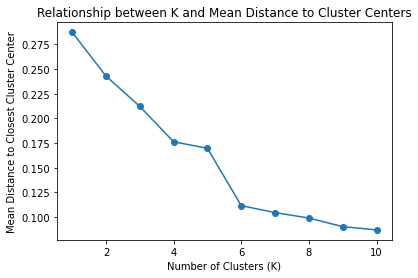

In [28]:
# Define K values to evaluate
K_values = range(1, 11)
mean_distances = []

# Iterate through different K values
for K in K_values:
    _, _, mean_distance = k_means(normalized_data, K)
    mean_distances.append(mean_distance)

# Plot relationship between K and mean distance
plt.plot(K_values, mean_distances, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean Distance to Closest Cluster Center')
plt.title('Relationship between K and Mean Distance to Cluster Centers')
plt.show()

2

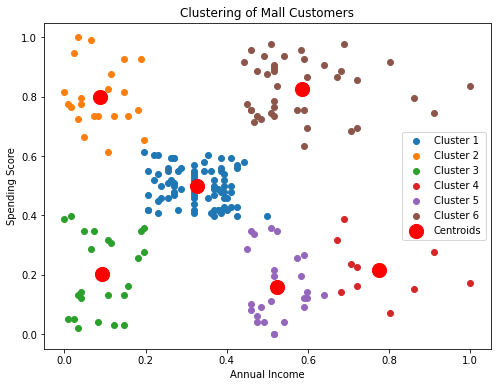

In [36]:
# Using the proper K value identified from the plot (e.g., K=5)
K = 6

# Train K-Means model
centers, clusters, _ = k_means(normalized_data, K)

# Plotting clusters with center markers
plt.figure(figsize=(8, 6))
for k in range(K):
    plt.scatter(normalized_data[clusters == k][:, 0], normalized_data[clusters == k][:, 1], label=f'Cluster {k+1}')
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, c='red', label='Centroids')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Clustering of Mall Customers')
plt.legend()
plt.show()

Cluster 1 (Blue): Customers in this cluster are on moderate income and have a moderate to high spending score. They might be considered the middle-income group that spends sensibly, possibly looking for quality and value in their purchases.

Cluster 2 (Orange): Customers here have lower to moderate incomes but are high spenders. They might represent younger demographics or trend-followers who, despite their lower income, prioritize spending on lifestyle and leisure.

Cluster 3 (Green): These customers have lower incomes and lower spending scores. They are likely very price-sensitive, looking for the most affordable options, discounts, and may prioritize essential needs.

Cluster 4 (Red): This group has higher incomes but does not spend as much, indicating they might be savers or investors, or they might be looking for high-value deals.

Cluster 5 (Purple): This cluster might represent customers with moderate to high income and low spending, possibly indicating a group that is financially comfortable but chooses to spend their money cautiously.

Cluster 6 (Brown): This cluster is characterized by high-income individuals with the highest spending scores. They likely represent affluent customers who frequently purchase premium products and services without much regard for cost.

(c)

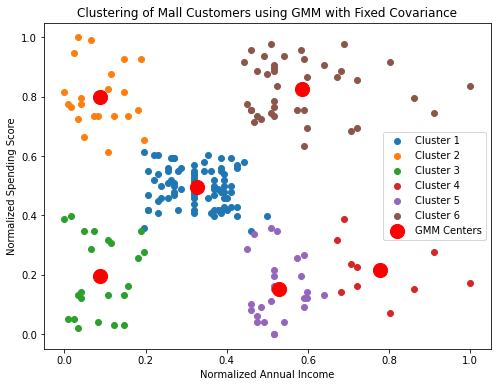

In [30]:
def initialize_centers(data, K):
    # Randomly initialize K centers from the data points
    np.random.seed(42)
    centers = data[np.random.choice(data.shape[0], K, replace=False)]
    
    weights = np.ones(K) / K
    
    # Fixed relatively small covariance matrix
    covariances = np.array([1e-3 * np.eye(data.shape[1])] * K)

    return weights, centers, covariances


def maximization_step_fixed_covariance(data, responsibilities, K):
    n_samples, n_features = data.shape
    weights = np.sum(responsibilities, axis=0) / n_samples
    means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0)[:, np.newaxis]

    # Covariances remain fixed as per the initialization
    covariances = np.array([1e-3 * np.eye(n_features)] * K)

    return weights, means, covariances

def gmm_algorithm_fixed_covariance(data, K, max_iter=100, tol=1e-4):
    weights, means, covariances = initialize_centers(data,K)

    prev_log_likelihood = -np.inf
    for i in range(max_iter):
        # Expectation step
        responsibilities = expectation_step(data, weights, means, covariances, K)

        # Maximization step with fixed covariances
        weights, means, covariances = maximization_step_fixed_covariance(data, responsibilities, K)

        # Calculate log-likelihood
        current_log_likelihood = score_samples(data, weights, means, covariances, K)

        # Check for convergence
        if np.abs(current_log_likelihood - prev_log_likelihood) < tol:
            break

        prev_log_likelihood = current_log_likelihood

    return weights, means, covariances, responsibilities

# Train GMM with fixed covariance
weights_gmm, means_gmm, _, responsibilities_gmm = gmm_algorithm_fixed_covariance(normalized_data, K)

# Assign clusters based on maximum responsibility
clusters_gmm = np.argmax(responsibilities_gmm, axis=1)

# Plotting clusters with GMM using fixed covariance
plt.figure(figsize=(8, 6))
for k in range(K):
    plt.scatter(normalized_data[clusters_gmm == k][:, 0], normalized_data[clusters_gmm == k][:, 1], label=f'Cluster {k+1}')
plt.scatter(means_gmm[:, 0], means_gmm[:, 1], marker='o', s=200, c='red', label='GMM Centers')
plt.xlabel('Normalized Annual Income')
plt.ylabel('Normalized Spending Score')
plt.title('Clustering of Mall Customers using GMM with Fixed Covariance')
plt.legend()
plt.show()

It is performing similarly to the K-Means Algorithm with the same K. When the covariance matrices in a Gaussian Mixture Model are fixed to a small value close to zero, the model tends to assign data points to the nearest cluster center just like K-Means, resulting in spherical clusters and a hard clustering effect. This is because a small covariance implies very little spread around the mean, making the probability densities peak sharply, which aligns closely with the nearest centroid-based assignment used in K-Means.